# AEcroscopy Manuscript Measurements Workflow




${Yongtao}$ ${Liu}$

${June}$ ${2023}$



### Install and Import

In [1]:
import os
import win32com.client
import numpy as np
import time
import h5py
import sidpy
import pyNSID
import matplotlib.pyplot as plt
from tqdm import tqdm

# import acquition.py
from Acquisition_v0_9 import Acquisition   # include the Acquistion_v.py in the same directory

### Start BEPyAE.exe and set VI

* Start BEPyAE.ext
* Set VI of BEPyAE; if this version includes PyScanner, also set VIs for PyScanner

In [2]:
newexp = Acquisition(exe_path = r"C:\Users\Asylum User\Desktop\Yongtao_Desktop\BEPyAE 060523 01\BEPyAE.exe")   
# exe_path is the directory of BEPyAE; 

### Initialize Igor AR18
* Set offline development
* Build a connection between BEPyAE and AR18
* Get parameters in AR18

In [3]:
newexp.init_BEPyAE(offline_development = False) # set offline_development=True if doing offline development
                                                # executing this will also initlize AR18

> Hereinafter 
> * If no parameters are provided in a function, executing the function will utilize the default parameters within $BEPyAE.exe$.
> * Certain functions provide feedback after execution, which can be disabled by setting $feedbackon=False$. This allows you to deactivate feedback during specific iterations or instances when it is not required.
> * Note: For tip locations, -1 corresponds to the left-hand side on the x-axis and the bottom side on the y-axis, while 1 corresponds to the right-hand side on the x-axis and the top side on the y-axis.

### Set tip parameters
* set setpoint, tip locations

![image1.PNG](../ht_workflows/image1.png)

In [4]:
newexp.tip_control(tip_parms_dict = {"set_point_V_00": 1, "next_x_pos_00": 0, "next_y_pos_01": 0},
                   do_move_tip = True, 
                   do_set_setpoint = True) # Executing this code will set setpoint to 1 V, 
                                           # and move tip to location [0, 0.5]

Setpoint is:  1.0
Tip parameters are:  (0.0, 0.0, 0.2)


### Set IO 
This defines IO parameters, such as AFM platform: AR18, amplifiers, channel data types, etc

In [5]:
newexp.define_io_cluster(IO_cluster_parms_dict = {"analog_output_amplifier_06": 1, 
                                                  "channel_01_type_07": 1, 
                                                  "channel_02_type_08": 2,
                                                  "channel_03_type_09": 3,})

('0 Cypher AR18',
 '6124',
 4000000.0,
 10.0,
 10.0,
 'AC and DC on AO0',
 10.0,
 'topography',
 'current',
 'aux',
 'external')

### Set BE pulse parameters 

In [6]:
# set BE parameters
newexp.define_be_parms(be_parms_dict = {"center_frequency_Hz_00": 350, "band_width_Hz_01": 100, "amplitude_V_02": 1, 
                                        "phase_variation_03": 1, "repeats_04": 4, "req_pulse_duration_s_05": 4,
                                        "auto_smooth_ring_06": 1},
                       do_create_be_waveform = True)

BE parameters are:  (350000.0, 100000.0, 1.0, 1.0, 4, 0.004, 1, 3352.2952763920002, 0.12159459061880915)


### BE Line scan
* This is a single BE line scan
* This returns 5 datasets: quick_fitting, complex spectra, and 3 channels

In [8]:
os.chdir(r"D:\WEST User data\Yongtao\AEcroscopy\Experiment3")

In [11]:
# Do a single line scan
qk_fit, com_spec, chn1, chn2, chn3 = newexp.do_line_scan(line_scan_parms_dict = {"num_BE_pulses_01": 32,
                                                                                 "start_x_pos_00": -1, "start_y_pos_01": -1,
                                                                                 "stop_x_pos_02": 1, "stop_y_pos_03": 1},
                                                         upload_to_daq = True, do_line_scan = True)

voltage offset and number of BE pulse are:  (0.0, 32)
line scan start and end positions:  (-1.0, -1.0, 1.0, 1.0)


### BE Raster Scan
* Square raster scan
* raster_scan returns 3 sidpy datasets: BEPFM quick fitting, channels, and BE complex spectra
* raster_scan also saves these 3 sidpy dataset in a hdf5 file

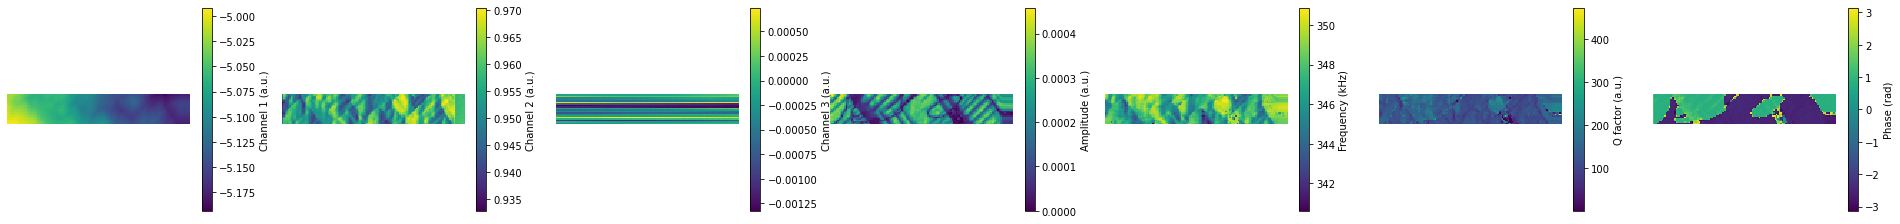

 [progress: 0:01:14] |******                                | (ETA:   0:06:00) 

KeyboardInterrupt: 

In [12]:
# Do a 128*128 raster scan
dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"scan_pixel": 128, "scan_x_start": -1,
                                                                       "scan_y_start": -1,"scan_x_stop": 1,
                                                                       "scan_y_stop": 1}, 
                                                  file_name = "BEPFM_3um")

Planned Experiment: domain writing, bias-PFM?, ...

## Experiment 1. High-throughput domain writing in ferroelectric materials

>In this experiment, we begin by applying a DC pulse to switch the ferroelectric polarization. Subsequently, a BEPFM (Band Excitation Piezoresponse Force Microscopy) measurement is conducted to image the domain structure.

1. To initiate the measurement process, we first need to determine the location for each individual measurement.If a new location is chosen for each measurement, we need a location array to record all the measurements as demonstrated below.

![image2.PNG](../ht_workflows/image2.png)

2. Prior to experiments, we also need to establish the DC pulse parameters including pulse magnitude $A$ and pulse length $t$ , as shown below. Again, there are two scenarios to consider here:

![image4.PNG](../ht_workflows/image4.png)

> * The pulse parameters can be pre-defined, e.g., the parameter values can be uniformly distributed within a specified range or customized to suit the experimental requirements.
> * The pulse parameters can be random values within a defined space, typically these random values is a uniform distribution across that space in principle.

### Prior to expeirment, set a directory to save data

In [ ]:
os.chdir("C:/AEcroscopy_manuscript/Experiment1")

### Step 1. Generate a location array

In [ ]:
# All locations span across [start_point_x, end_point_x] in x-direction and [start_point_y, end_point_y] in y-direction.
# There are num_x rows and num_y columns in the locations array

start_point_x = -0.9   # Define location array parameters
end_point_x = 0.9
start_point_y = -0.9
end_point_y = 0.9
num_x = 2
num_y = 2

# Generate location array
pos_x = np.linspace(-0.9, 0.9, num_x)
pos_y = np.linspace(-0.9, 0.9, num_y)
pulse_pos = np.meshgrid(pos_x, pos_y)
pulse_pos_x = pulse_pos[0].reshape(-1)
pulse_pos_y = pulse_pos[1].reshape(-1)  # pulse_pos_x and pulse_pos_y are the coordinates of all locations

# Set BEPFM image size
img_size = 0.1

# Check
if img_size > np.abs(pos_x[0]-pos_x[1]):
    print ("Alert: there will be image overlap along x-direction")
elif img_size > np.abs(pos_y[0]-pos_y[1]):
    print ("Alert: there will be image overlap along y-direction")
else:
    print("{} locations are ready for experiments".format(len(pulse_pos_x)))

### Step 2. Establish pulse parameters 

In [ ]:
# uniformly distributed pulse parameters
min_voltage = 5
max_voltage = 9
Vdc_amp = np.linspace(min_voltage, max_voltage, num_x)  # pulse magnitude

min_time_log = -4
max_time_log = 1
Vdc_time = np.linspace(min_time_log, max_time_log, num_y, dtype = np.float32())
Vdc_time = np.power(10, Vdc_time)                 # pulse time

# Establish pulse parameters
Vdc = np.meshgrid(Vdc_amp, Vdc_time)
Vdc_amp = Vdc[0].reshape(-1)
Vdc_time = Vdc[1].reshape(-1)

if len(Vdc_amp) > len(pulse_pos_x):
    print ("Error: No enough locations to test all pulse conditions")
else:
    print ("{} pulse parameters are ready for expierments".format(len(Vdc_amp)))
    
# save pulse condition
np.save("Vdc_list.npy", np.asarray([Vdc_amp, Vdc_time]))

### Step 3. Start experiment

In [ ]:
for i in tqdm(range(len(Vdc_amp))):
    #####################----------- Move tip to the pulse location -----------##################### 
    newexp.tip_control(tip_parms_dict = {"set_point_V_00": 1,
                                         "next_x_pos_00": pulse_pos_x[i],
                                         "next_y_pos_01": pulse_pos_y[i]},
                       do_move_tip = True, do_set_setpoint = True)
    time.sleep(0.2)
    
    #####################----------- Apply pulse -----------##################### 
    V_amp = Vdc_amp[i]
    V_time = Vdc_time[i]
    
#     # upload pulse
#     newexp.define_apply_pulse(pulse_parms_dict = {"pulse_init_amplitude_V_00": 0, "pulse_mid_amplitude_V_01": V_amp,
#                                                   "pulse_final_amplitude_V_02": 0, "pulse_on_duration_s_03": V_time,
#                                                   "rise_time_s_05": 1E-4, "pulse_final_duration_s_04": 20E-3,
#                                                   "pulse_repeats_06": 1},
#                               do_create_pulse = True, do_upload_pulse = True, do_apply_pulse = False)
#     time.sleep(1)
    # upload and apply pulse
    pulse value, pulse_time = newexp.define_apply_pulse(pulse_parms_dict = {"pulse_init_amplitude_V_00": 0, 
                                                                            "pulse_mid_amplitude_V_01": V_amp,
                                                                            "pulse_final_amplitude_V_02": 0, 
                                                                            "pulse_on_duration_s_03": V_time,
                                                                            "rise_time_s_05": 1E-4, 
                                                                            "pulse_final_duration_s_04": 20E-3,
                                                                            "pulse_repeats_06": 1},
                                                        do_create_pulse = True, do_upload_pulse = True, do_apply_pulse = True)
    f1, ax = plt.subplots(figsize = (4, 3), dpi = 100)
    f1.suptitle("Applied pulse")
    ax.plot(pulse_time, pulse_value)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Voltage (V)")
    plt.show()
    
    time.sleep(1)
    
    #####################----------- Do BEPFM to image domain -----------#####################
    dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"scan_pixel": 16,
                                                                           "scan_x_start": pulse_pos_x[i]-(img_size/2), 
                                                                           "scan_y_start": pulse_pos_y[i]-(img_size/2),
                                                                           "scan_x_stop": pulse_pos_x[i]+(img_size/2), 
                                                                           "scan_y_stop": pulse_pos_y[i]+(img_size/2)},
                                                      file_name = "Domain_Writing_{}".format(i), 
                                                      progress_on = False, ploton = False)
    time.sleep(0.5)
    
    # Plot BEPFM images
    f2, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (30, 5), dpi = 100)
    ax1.imshow(dset_pfm[:,:,0], origin = "lower"); ax1.set_title("Amplitude")
    ax2.imshow(dset_pfm[:,:,1], origin = "lower"); ax2.set_title("Frequency")
    ax3.imshow(dset_pfm[:,:,2], origin = "lower"); ax3.set_title("Q Factor")
    ax4.imshow(dset_pfm[:,:,3], origin = "lower"); ax4.set_title("Phase")
    ax5.imshow(dset_chns[0,:,:], origin = "lower"); ax5.set_title("Topography")
    ax6.imshow(dset_chns[1,:,:], origin = "lower"); ax6.set_title("Deflection")
    plt.show()

### Step 4. Do a BEPFM at the whole experiment area

In [ ]:
dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"scan_pixel": 32, "scan_x_start": -1.0,
                                                                       "scan_y_start": -1.0,"scan_x_stop": 1.0,
                                                                       "scan_y_stop": 1.0}, 
                                                  file_name = "PFM_whole", ploton = False)

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (30, 5), dpi = 100)
ax1.imshow(dset_pfm[:,:,0], origin = "lower"); ax1.set_title("Amplitude")
ax2.imshow(dset_pfm[:,:,1], origin = "lower"); ax2.set_title("Frequency")
ax3.imshow(dset_pfm[:,:,2], origin = "lower"); ax3.set_title("Q Factor")
ax4.imshow(dset_pfm[:,:,3], origin = "lower"); ax4.set_title("Phase")
ax5.imshow(dset_chns[0,:,:], origin = "lower"); ax5.set_title("Topography")
ax6.imshow(dset_chns[1,:,:], origin = "lower"); ax6.set_title("Deflection")
plt.show()

## Experiment 2. Ferroelectric Domain Wall Width as a Function of Drive Amplitude and Setpoint

### Prior to expeirment, set a directory to save data

In [ ]:
os.chdir("C:/AEcroscopy_manuscript/Experiment2")

### Step 1. Establish AC Amplitude and Setpoint Parameters

In [ ]:
# uniformly distributed AC amplitude
min_ac = 0.5
max_ac = 5
num_ac = 10
Vac = np.linspace(min_ac, max_ac, num_x)  # AC amplitude

# uniformly distributed setpoint values
min_setpoint = 0.5
max_setpoint = 5
num_setpoint = 10
setpoint = np.linspace(min_setpoint, max_setpoint, num_setpoint)  # Setpoint

# Establish AC and setpoint parameters array
Vac_setpoint = np.meshgrid(Vac, setpoint)
Vac = Vac_setpoint[0].reshape(-1)
setpoint = Vac_setpoint[1].reshape(-1)

print ("{} AC and setpoint parameters are ready for expierments".format(len(Vac)))
    
# save pulse condition
np.save("Vac_setpoint.npy", np.asarray([Vac, setpoint]))

### Step 2. Write a Domain Wall

In [ ]:
# Set AC voltage to 0
newexp.define_be_parms(be_parms_dict = {"center_frequency_Hz_00": 335, "band_width_Hz_01": 10, "amplitude_V_02": 0},
                       do_create_be_waveform = True)  
# Scan over left half side with -5 V applied to tip to switching polarization, so that a domain wall is writted at the middle
_, _, _ = newexp.raster_scan(raster_parms_dict = {"tip_voltage": -5, "scan_pixel": 128, "scan_x_start": -1.0, 
                                                  "scan_y_start": 0, "scan_x_stop": 1.0, "scan_y_stop": 1.0},
                             file_name = "domain_wall_writing", ploton = False)

### Step 3. Perform BEPFM to image the domain wall with various AC and setpoint 

In [ ]:
for i in tpdm(range(len(Vac))):
    # select AC and setpoint
    be_amp = Vac[i]
    spoint = setpoint[i]
    # Set setpoint
    newexp.tip_control(tip_parms_dict = {"set_point_V_00": spoint}, do_move_tip = False, do_set_setpoint = True)
    # Set BE pulse amplitude
    newexp.define_be_parms(be_parms_dict = {"center_frequency_Hz_00": 335, "band_width_Hz_01": 100, "amplitude_V_02": be_amp},
                           do_create_be_waveform = True)
    
    # Perform BEPFM image measurement
    dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"tip_voltage": 0, "scan_pixel": 128, 
                                                                           "scan_x_start": -1.0, "scan_y_start": -1.0,
                                                                           "scan_x_stop": 1.0, "scan_y_stop": 1.0},
                                                      file_name = "Domain_wall_width", ploton = False)

    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (30, 5), dpi = 100)
    ax1.imshow(dset_pfm[:,:,0], origin = "lower"); ax1.set_title("Amplitude")
    ax2.imshow(dset_pfm[:,:,1], origin = "lower"); ax2.set_title("Frequency")
    ax3.imshow(dset_pfm[:,:,2], origin = "lower"); ax3.set_title("Q Factor")
    ax4.imshow(dset_pfm[:,:,3], origin = "lower"); ax4.set_title("Phase")
    ax5.imshow(dset_chns[0,:,:], origin = "lower"); ax5.set_title("Topography")
    ax6.imshow(dset_chns[1,:,:], origin = "lower"); ax6.set_title("Deflection")
    plt.show()

## Experiment 3. Spiral Scans 

AEcroscopy allows various scan trajectories, such as spiral, lissajour scans, as well as arbitrary scan. Here we show examples of spiral scan in band excitation PFM, however, these scan trajectories can also be used in other experiment, such as KPFM (ref [])

### Prior to expeirment, set a directory to save data

In [ ]:
os.chdir("C:/AEcroscopy_manuscript/Experiment3")

### Step 1. Set BE pulse parameters

In [ ]:
# Set BE pulse amplitude
newexp.define_be_parms(be_parms_dict = {"center_frequency_Hz_00": 350, "band_width_Hz_01": 100, "amplitude_V_02": 1},
                       do_create_be_waveform = True)

### Step 2. Perform a raster scan as a reference to compare with spiral and lissajour scan results.

In [ ]:
# Perform BEPFM image measurement
start_time = time.time()
dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"tip_voltage": 0, "scan_pixel": 128,
                                                                       "scan_x_start": -1.0, "scan_y_start": -1.0,
                                                                       "scan_x_stop": 1.0, "scan_y_stop": 1.0},
                                                  file_name = "Domain_wall_width", ploton = False)
timecost_raster = time.time() - start_time

# Plot raster scan result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5), dpi = 100)
ax1.imshow(dset_pfm[:,:,0], origin = "lower"); ax1.set_title("Amplitude")
ax2.imshow(dset_pfm[:,:,1], origin = "lower"); ax2.set_title("Frequency")
ax3.imshow(dset_pfm[:,:,2], origin = "lower"); ax3.set_title("Q Factor")
ax4.imshow(dset_pfm[:,:,3], origin = "lower"); ax4.set_title("Phase")
plt.show()

### Step 3. Perform a spiral scan BEPFM

In [ ]:
# newexp.fpga_spiral_scan(spiral_parms_dict = {"spiral_inner_radius_x_V_00": 0, "spiral_outer_radius_x_V_01": 1,
#                                              "spiral_inner_radius_y_V_02": 0, "spiral_outer_radius_y_V_03": 1,
#                                              "spiral_N_cycles_04": 10, "spiral_duration_05": 1}, 
#                         do_scan_update = True, do_scan = False, 
#                         file_name = "spiral_scan")

In [ ]:
# fpgaresult = newexp.fpga_spiral_scan(do_scan_update = True, do_scan = True, file_name = "spiral_scan")

In [ ]:
# spiral scan BEPFM
newexp.fpga_spiral_scan_BE(spiral_parms_dict = {"spiral_inner_radius_x_V_00": 0,"spiral_outer_radius_x_V_01": 1,
                                                "spiral_inner_radius_y_V_02": 0,"spiral_outer_radius_y_V_03": 1,
                                                "spiral_N_cycles_04": 5},
                           num_BE_pulse = 1024, do_scan_update = True,
                           do_BE_arb_line_update_00 = True, do_BE_arb_line_scan_01 = False)

In [ ]:
start_time = time.time()
# spiral scan BEPFM
fpga_result, be_result = newexp.fpga_spiral_scan_BE(spiral_parms_dict = {"spiral_inner_radius_x_V_00": 0, 
                                                                         "spiral_outer_radius_x_V_01": 1,
                                                                         "spiral_inner_radius_y_V_02": 0, 
                                                                         "spiral_outer_radius_y_V_03": 1,
                                                                         "spiral_N_cycles_04": 40},
                                                    num_BE_pulse = 2048, do_scan_update = True, 
                                                    do_BE_arb_line_update_00 = True, do_BE_arb_line_scan_01 = True,
                                                    spiral_reconstruction = False)
timecost_spiral = time.time() - start_time

# # Plot spiral BE results
# # be = be_result['reconstruction']
# f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5), dpi = 100)
# ax1.imshow(be[:,:,0], origin = "lower"); ax1.set_title("Amplitude")
# ax2.imshow(be[:,:,1], origin = "lower"); ax2.set_title("Frequency")
# ax3.imshow(be[:,:,2], origin = "lower"); ax3.set_title("Q Factor")
# ax4.imshow(be[:,:,3], origin = "lower"); ax4.set_title("Phase")
# plt.show()

In [ ]:
    # Spiral reconstruction function
    def newspiral_be_reconstruction(sho_guess_cluster, output_xy, image_mask, sample_factor=32, 
                                 num_image_pixels=200, itern=1, levels=3, lambd=3, cut_thresh=0.95):
        # BE line data
        sho_guess = np.asarray(sho_guess_cluster)
            
        # Sample
        output_x = np.asarray(output_xy[0])
        output_y = np.asarray(output_xy[1])
        outx_downsampled = output_x[::output_x.shape[0]//sho_guess.shape[0]//sample_factor]
        outy_downsampled = output_y[::output_y.shape[0]//sho_guess.shape[0]//sample_factor]
        outx_max = np.max(np.abs(outx_downsampled))
        outy_max = np.max(np.abs(outy_downsampled))
        xy_max = np.max([outx_max, outy_max])

        #The x and y positions are to convert to in pixels
        x_downsampled = 0.5*(outx_downsampled * num_image_pixels/outx_max + num_image_pixels)
        y_downsampled = 0.5*(outy_downsampled * num_image_pixels/outy_max + num_image_pixels)

        sho_amp = sho_guess[:,0]
        sho_pha = sho_guess[:,3]
        new_us = np.linspace(0, sho_amp.shape[0], sho_amp.shape[0]*sample_factor)
        sho_amp_interp = np.interp(new_us, np.arange(0, sho_amp.shape[0]), sho_amp)
        sho_pha_interp = np.interp(new_us, np.arange(0, sho_pha.shape[0]), sho_pha)

        z_img = np.zeros((image_mask.shape[0], image_mask.shape[1], 2))

        for j in range(int(sho_amp_interp.shape[0]*cut_thresh)):
            pos = [int(x_downsampled[j]), int(y_downsampled[j])]
            pos[0] = np.clip(pos[0],0, image_mask.shape[0]-1)
            pos[1] = np.clip(pos[1],0,image_mask.shape[1]-1)
            z_img[pos[0], pos[1],0] = sho_amp_interp[j]*1E3
            z_img[pos[0], pos[1],1] = sho_pha_interp[j]

        mask_ = np.zeros(z_img[:,:,0].shape)
        for i1 in range(z_img[:,:,0].shape[0]):
            for i2 in range(z_img[:,:,0].shape[1]):
                if abs(z_img[i1,i2,0]) > 0:
                    mask_[i1,i2] = 1

        #Now do CS reconstructions
        reconstructions = []
        for k in range(2):
            try:
                reconstruction=self.SSTEM(np.abs(z_img[:,:,k]), mask_, itern, levels, lambd)
                reconstructions.append(reconstruction)
            except:
                print("reconstruction failed in {} iterations".format(k))
                pass

        return reconstructions, z_img

In [ ]:
be_line_result =newexp.VI.getcontrolvalue("BE_line_scan_indicator_cluster")
sho_guess_cluster = be_line_result[3]
output_xy = [newexp.VIs.getcontrolvalue('AO0_V'), newexp.VIs.getcontrolvalue('AO1_V')]
image_mask = np.array(newexp.VIs.getcontrolvalue("image_mask"))

In [ ]:
reconstructions, piezo_list,_,_,mask, num_points_image = get_be_cs_scan_data(newexp, 
                                                                             piezo_list = [np.asarray(output_xy[0]), np.asarray(output_xy[0])], 
                                                                             upsample_factor = 32, lambd=3, levels=3, itern=1)

In [ ]:
for i in range (2, 7):
    for j in range (5, 10):
        print ("levels {}, itern {}".format(i*3, j/10))
        reconstructions, _,_,_,_,_ = get_be_cs_scan_data(newexp, 
                                                         piezo_list = [np.asarray(output_xy[0]), np.asarray(output_xy[0])],
                                                         upsample_factor = 32, lambd=j, levels=i*3, itern=1)
        recon = np.asarray(reconstructions)
        plt.figure()
        try:
            plt.imshow(recon[0])
        except:
            pass
        plt.show()

In [ ]:
recon = np.asarray(reconstructions)
recon.shape
plt.imshow(recon[0])

In [ ]:
reconstructions, _,_,_,_,_ = get_be_cs_scan_data(newexp, 
                             piezo_list = [np.asarray(output_xy[0]), np.asarray(output_xy[0])],
                             upsample_factor = 16, lambd=3, levels=1, itern=1)

In [ ]:
reconstructions[0].shape

plt.figure()
plt.imshow(reconstructions[0])

In [ ]:
reconstructions, z_img = newspiral_be_reconstruction(sho_guess_cluster, output_xy, image_mask, levels = 3)


In [ ]:
plt.imshow(z_img[:,:,1])

In [ ]:
# @jit(nopython=True)
def return_zimg(z_img, sho_amp_interp, sho_ph_interp, x_downsampled, y_downsampled, mask, cut_thresh = 0.95):
    for ind in range(int(sho_amp_interp.shape[0]*cut_thresh)):
        position = [int(x_downsampled[ind]), int(y_downsampled[ind])]
        position[0] = np.clip(position[0],0,mask.shape[0]-1)
        position[1] = np.clip(position[1],0,mask.shape[1]-1)
        z_img[position[0], position[1],0] = sho_amp_interp[ind]*1E3
        z_img[position[0], position[1],1] = sho_ph_interp[ind]
    return z_img

# @jit(nopython=True)
def return_mask(z_img, mask_new):
    for ii in range(z_img[:,:,0].shape[0]):
        for jj in range(z_img[:,:,0].shape[1]):
            if abs(z_img[ii,jj,0]) > 0:
                mask_new[ii,jj] = 1
    return mask_new

import pywt

def SSTEM(yspar,mask,itern,levels,lambd):  
    """
    INPUT: 
        -yspar: sparse image as an array, to reduce iteration numer, better rescaling the value to [0,1]
        -mask: binary array, 1 indicationg sampled pixel locations
        -itern: iteration number, usually 20 is enough
        -levels: wavelet level, common choice 2,3,4, larger value for larger feature size, if too blur, change to smaller one
        -lambd: threshold value, usually 0.8 is fine
    OUTPUT: 
        -Reconstructed image
    """
    
    fSpars = yspar
    W_thr = [0]*levels;

    ProjC = lambda f, Omega: (1-Omega)*f + Omega*yspar
    
    for i in range(itern):
        fSpars = ProjC(fSpars, mask)
        W_pro = pywt.swt2(fSpars, 'db2',levels)
        for j in range(levels):
            sA = W_pro[j][0]
            sH = W_pro[j][1][0]
            sV = W_pro[j][1][1]
            sD = W_pro[j][1][2]
            W_thr[j] = (pywt.threshold(sA,0,'soft')),(pywt.threshold(sH,lambd,'soft'),
                        pywt.threshold(sV,lambd,'soft'),pywt.threshold(sD,lambd,'soft'))    
        fSpars = pywt.iswt2(W_thr,'db2')
    return fSpars

def line_scan_data(VI_ref):
    line_data = VI_ref.getcontrolvalue('BE_line_scan_indicator_cluster')
    daq_wave = line_data[0]
    complex_spectra = line_data[1]
    shoguessfit = line_data[3]
    topo = line_data[4]

    return daq_wave, complex_spectra, shoguessfit, topo

def get_be_cs_scan_data(acquisition_handle, piezo_list = None, 
                        upsample_factor = 32, lambd=3, levels=3, itern=1):
    
    mask = np.array(acquisition_handle.VIs.getcontrolvalue("image_mask"))
    num_points_image = acquisition_handle.VIs.getcontrolvalue('N_image_pixels')
    
    daq_wave, complex_spectra, shoguessfit, topo = line_scan_data(acquisition_handle.VI)
    
    if piezo_list is None:
        ao0 = np.array(acquisition_handle.VIs.getcontrolvalue('AO0_V'))
        ao1 = np.array(acquisition_handle.VIs.getcontrolvalue('AO1_V'))
    else:
        ao0 = piezo_list[0]
        ao1 = piezo_list[1]
        
    sho_qf = np.array(shoguessfit)
    reconstructions,piezo_list = do_CS_for_BE(sho_qf,mask, ao0,ao1, num_points_image,
                                              upsample_factor=upsample_factor, lambd=lambd,
                                             levels = levels, itern = itern)
    
    return reconstructions, piezo_list, sho_qf, complex_spectra, mask, num_points_image

def do_CS_for_BE(sho_qf,mask,ao0,ao1,num_points_image,upsample_factor, itern,
                 levels,lambd, cut_thresh=0.95):
    
    ao0_downsampled = ao0[::ao0.shape[0]//sho_qf.shape[0]//upsample_factor]
    ao1_downsampled = ao1[::ao1.shape[0]//sho_qf.shape[0]//upsample_factor]

    max_x = np.max(np.abs(ao0_downsampled))
    max_y = np.max(np.abs(ao1_downsampled))
    max_value = np.max([max_x, max_y])

    #since the offsets don't matter, the x and y positions are straightforward to convert to in pixels
    x_downsampled = 0.5*(ao0[::ao0.shape[0]//sho_qf.shape[0]//upsample_factor] * num_points_image/max_value + num_points_image)
    y_downsampled = 0.5*(ao1[::ao0.shape[0]//sho_qf.shape[0]//upsample_factor] * num_points_image/max_value + num_points_image)

    sho_amp = sho_qf[:,0]
    
    sho_phase = sho_qf[:,3]
    new_us = np.linspace(0,sho_amp.shape[0],sho_amp.shape[0]*upsample_factor)
    sho_amp_interp = np.interp(new_us, np.arange(0, sho_amp.shape[0]), sho_amp)
    sho_ph_interp = np.interp(new_us, np.arange(0, sho_amp.shape[0]), sho_phase)

    z_img = np.zeros((mask.shape[0],mask.shape[1],2))
    z_img = return_zimg(z_img, sho_amp_interp,sho_ph_interp, x_downsampled, y_downsampled, mask, cut_thresh)
    mask_ph=np.zeros(z_img[:,:,0].shape)
    mask_new = return_mask(z_img,mask_ph)
    
    #Now do CS
    reconstructions = []
    for ind in range(5):
        try:
            recons=SSTEM(np.abs(z_img[:,:,ind]),mask_new,itern,levels,lambd)
            reconstructions.append(recons)
        except:
            pass
       # reconstructions.append(recons)
        
    return reconstructions, [x_downsampled,y_downsampled, ao0_downsampled,ao1_downsampled]

def get_next_action(state,piezo_vp_list):
    
    x_downsampled,y_downsampled,a0_downsampled,a1_downsampled  = piezo_vp_list
    pix = state.shape[1]
    
    ini_wall_pos, _ = get_sigmoid_wall(state, clip_inds = [int(pix*0.20), int(pix*0.80)])
    
    #Now randomly apply voltage and pulse widths
    ypos_pix = int(np.random.randint(low=0.3*state.shape[0], high = 0.7*state.shape[0] )) +10
    xpos_pix = int(ini_wall_pos[int(ypos_pix)])+10
    
    print('xpos_pix {}, ypos_pix {}'.format(xpos_pix, ypos_pix))
    
    x_downsampled = np.array(x_downsampled, dtype = int)
    y_downsampled = np.array(y_downsampled, dtype = int)
    
    xpos_ind = np.where(xpos_pix==y_downsampled)[0][0]
    ypos_ind = np.where(ypos_pix==x_downsampled)[0][0]
    
    try:
        xpos_v = a0_downsampled[xpos_ind]
        ypos_v = a1_downsampled[xpos_ind]
    except:
        xpos_v = 0
        ypos_v = 0
        
    voltage_value = np.random.uniform(-8,8)
    pulse_width = np.random.uniform(0, 300)*1E-3
    
    next_action = [ypos_pix,xpos_pix,xpos_v,ypos_v,voltage_value,pulse_width]
    
    return next_action

from scipy.optimize import curve_fit

def sigmoid(x, *parms):
    a,b,Offset = parms
    return 1.0 / (1.0 + np.exp(-1.0 * a * (x - b))) + Offset

def rev_sigmoid(x, *parms):
    a,b,Offset = parms
    return np.exp(-1.0 * a * (x - b)) / (1.0 + np.exp(-1.0 * a * (x - b))) + Offset


def norm_image(arr):
    return (arr - np.amin(arr))/(np.ptp(arr))

def get_sigmoid_wall(phase_profile, clip_inds = [40, 80],
                     ind = None):
    
    if clip_inds is None:
        clip_inds = [0, phase_profile.shape[1]]
    
    phase_cons = phase_profile[:, clip_inds[0]:clip_inds[1]]
    xvals = np.arange(clip_inds[0], clip_inds[1])
    prior_b = (clip_inds[0] + clip_inds[1])/2
    
    if ind is None:
        wall_pos, wall_width = [], []
        for j in range(phase_cons.shape[0]):
            try:
                yvals = (phase_cons[j] - np.amin(phase_cons[j])) / np.ptp(phase_cons[j])
                fit_values = curve_fit(rev_sigmoid, xvals, yvals, p0 = [0.75, prior_b, 0], maxfev = 10000)
  
                wall_pos.append(fit_values[0][1])
                wall_width.append(fit_values[0][0])
            
            except:

                wall_pos.append(0)
                wall_width.append(0)
            
    else:
        try:
            yvals = (phase_cons[ind] - np.amin(phase_cons[ind])) / np.ptp(phase_cons[ind])
            fit_values = curve_fit(rev_sigmoid, xvals, yvals, p0 = [0.75, prior_b, 0], maxfev = 10000)
            
            wall_pos = fit_values[0][1]
            wall_width = (fit_values[0][0])
        except:
            print('Im not there')
            wall_pos, wall_width = 0,0
            
    return wall_pos, wall_width

In [ ]:
sho = np.asarray(sho_guess_cluster)

sho.shape

In [ ]:
plt.plot(sho[:,1])

In [ ]:
fgparesult = fpga_result
beresult = be_result

In [ ]:
print ("Compare the time cost of raster and spiral scan: ")
print ("time cost for raster scan is {}s and for spiral scan is {}s".format(timecost_raster, timecost_spiral))

## Experiment 4. Spectroscopy Measurements at Specific Objects 

AEcroscopy also enables spectroscopy at pre-defined objects in an automated manner, e.g. in-plane a-domains. Here we will show you how to perform piezoresonse spectroscopy measurements at only ferroelastic a-domains as an example. However, this can also be used in other spectroscopy modes (e.g., force-distance curve, current-voltage curve) and to measure other objects (e.g., domain wall, grain boundary).

### Prior to expeirment, set a directory to save data

In [7]:
os.chdir(r"D:\WEST User data\Yongtao\AEcroscopy\Experiment3")

### Step 1. Perform a BEPFM to image domain structures

 [progress: 0:22:51] |************************************* | (ETA:   0:00:05) C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


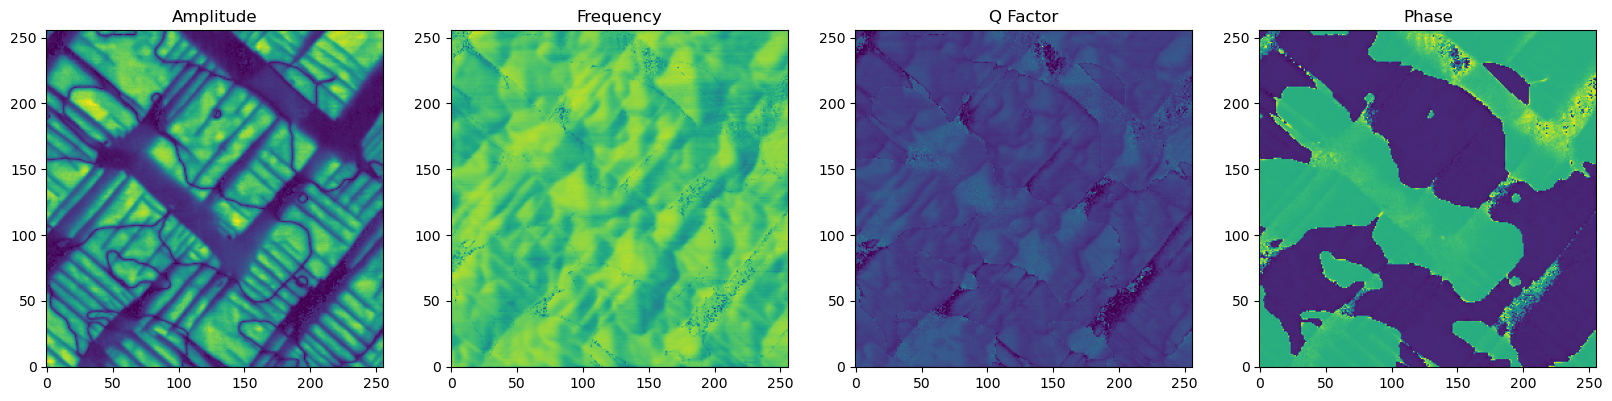

In [32]:
dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"tip_voltage": 0, "scan_pixel": 256,
                                                                       "scan_x_start": -1.0, "scan_y_start": -1.0,
                                                                       "scan_x_stop": 1.0, "scan_y_stop": 1.0},
                                                  file_name = "BEPFM_structure_3um", ploton = False)

# plot results
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5), dpi = 100)
ax1.imshow(dset_pfm[:,:,0], origin = "lower"); ax1.set_title("Amplitude")
ax2.imshow(dset_pfm[:,:,1], origin = "lower"); ax2.set_title("Frequency")
ax3.imshow(dset_pfm[:,:,2], origin = "lower"); ax3.set_title("Q Factor")
ax4.imshow(dset_pfm[:,:,3], origin = "lower"); ax4.set_title("Phase")
plt.show()

### Step 2. Apply a threshold filter to extract a-domain location from amplitude image

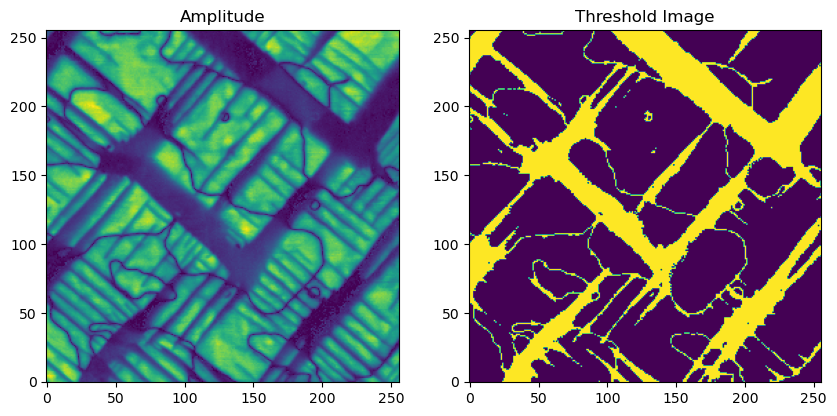

In [33]:
# normalize amplitude image
amplitude = np.asarray(dset_pfm[:,:,0])
amplitude_nor = (amplitude - amplitude.min())/amplitude.ptp()

# apply a threshold filter
thresh = np.copy(amplitude_nor)
th = 0.2
thresh[amplitude_nor < th] = 1 # set a-domain locations as 1
thresh[amplitude_nor >= th] = 0 # set non a-domain locations as 0

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5), dpi =100)
ax1.imshow(amplitude_nor, origin = "lower"); ax1.set_title("Amplitude")
ax2.imshow(thresh, origin = "lower"); ax2.set_title("Threshold Image")
plt.show()

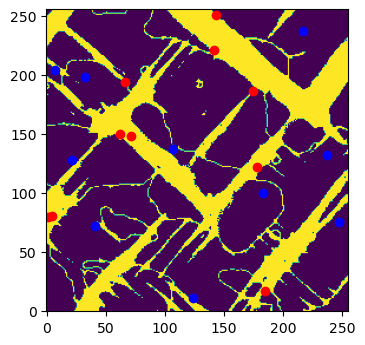

In [50]:
# select some random locations from a-domain to perform BEPS measurement
adomain_locations = np.asarray(np.where(thresh == 1))
# select 10 random location
random_idx = np.random.choice(adomain_locations.shape[1], size = 10, replace=False)
np.random.seed(60)
selected_locations_a = adomain_locations[:,random_idx]
np.save("locations_a.npy", np.asarray(selected_locations_a))

# select some random locations from c-domain to perform BEPS measurement
cdomain_locations = np.asarray(np.where(thresh == 0))
# select 10 random location
random_idx = np.random.choice(cdomain_locations.shape[1], size = 10, replace=False)
selected_locations_c = cdomain_locations[:,random_idx]
np.save("locations_c.npy", np.asarray(selected_locations_c))

# plot selected locations
f, ax = plt.subplots(dpi = 100)
ax.imshow(thresh, origin = "lower")
ax.scatter(selected_locations_a[1], selected_locations_a[0], c = 'r')
ax.scatter(selected_locations_c[1], selected_locations_c[0], c = 'blue')
plt.show()

### Step 3. Perform BEPS measurements at selected locations

In [51]:
# Define BEPS parameters
newexp.define_BEPS_parameters(beps_parms_dict = {"amplitude_V_00": 20, "step_per_cycle_03": 64,
                                                "num_cycles_04": 3}, do_create_waveform = True)

BEPS parameters are:  (20.0, 0.0, 0.0, 64, 3, 0, 0, 0, 0.001, 0.0, 0.0, 0.0, 1, 0, 8.0, 8.0, 7.0, -7.0, False, False, False)


In [52]:
# Convert coordinates in image to tip location values
convert_locations = newexp.convert_coordinates(original_coordinates=selected_locations_a, num_pix_x=256, num_pix_y=256)

# Perform BEPS at each location
for i in range (len(convert_locations[0])):
    wv, quick_fit, cx, chns = newexp.do_beps_specific(coordinates = np.asarray([convert_locations[1, i], convert_locations[0, i]]),
                                                     file_name = "BEPS_at_A_domain_{}".format(i))

 [progress: 0:00:03] |                                      | (ETA:  --:--:--) C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
 [progress: 0:00:03] |                                      | (ETA:  --:--:--) C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed 

In [54]:
# Convert coordinates in image to tip location values
convert_locations = newexp.convert_coordinates(original_coordinates=selected_locations_c, num_pix_x=256, num_pix_y=256)

# Perform BEPS at each location
for i in range (len(convert_locations[0])):
    wv, quick_fit, cx, chns = newexp.do_beps_specific(coordinates = np.asarray([convert_locations[1, i], convert_locations[0, i]]),
                                                     file_name = "BEPS_at_C_domain_{}".format(i))

 [progress: 0:00:03] |                                      | (ETA:  --:--:--) C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
 [progress: 0:00:03] |                                      | (ETA:  --:--:--) C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed 

In [73]:
amp_off_a = np.zeros((10, 192))
amp_on_a = np.zeros((10, 192))
pha_off_a = np.zeros((10, 192))
pha_on_a = np.zeros((10, 192))
for j in range (len(convert_locations[0])):
    hf = h5py.File("BEPS_at_A_domain_{}_0.hf5".format(j))
    #sidpy.hdf.hdf_utils.print_tree(hf)
    vw = hf["BEPS/vdc_waveform"]
    vw = np.asarray(vw)

    amp = hf["BE Quick Fitting/Quick Fitting/Quick Fitting"][0,0,]
    pha = hf["BE Quick Fitting/Quick Fitting/Quick Fitting"][0,3,]
    for i in range (192):
        amp_off_a[j, i] = amp[i*2 + 1]
        amp_on_a[j, i] = amp[i*2]
        pha_off_a[j, i] = pha[i*2 + 1]
        pha_on_a[j, i] = pha[i*2]


In [74]:
amp_off_c = np.zeros((10, 192))
amp_on_c = np.zeros((10, 192))
pha_off_c = np.zeros((10, 192))
pha_on_c = np.zeros((10, 192))
for j in range (len(convert_locations[0])):
    hf = h5py.File("BEPS_at_C_domain_{}_0.hf5".format(j))
    #sidpy.hdf.hdf_utils.print_tree(hf)
    vw = hf["BEPS/vdc_waveform"]
    vw = np.asarray(vw)

    amp = hf["BE Quick Fitting/Quick Fitting/Quick Fitting"][0,0,]
    pha = hf["BE Quick Fitting/Quick Fitting/Quick Fitting"][0,3,]
    for i in range (192):
        amp_off_c[j, i] = amp[i*2 +1]
        amp_on_c[j, i] = amp[i*2]
        pha_off_c[j, i] = pha[i*2 + 1]
        pha_on_c[j, i] = pha[i*2]

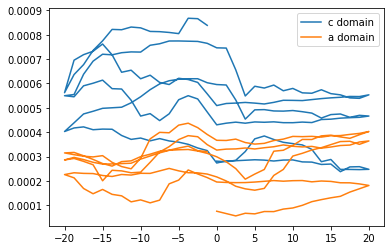

In [72]:
plt.plot(vw, amp_off_c.mean(0), label = "c domain")
plt.plot(vw, amp_off_a.mean(0), label = "a domain")
plt.legend()

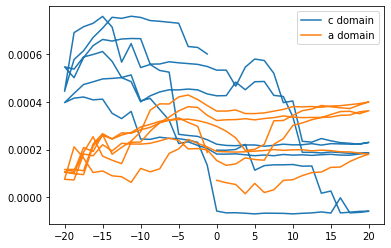

In [78]:
amp_c = amp_off_c.mean(0); pha_c = pha_off_c.mean(0); piezo_c = amp_c*np.cos(pha_c)
amp_a = amp_off_a.mean(0); pha_a = pha_off_a.mean(0); piezo_a = amp_a*np.cos(pha_a)
plt.plot(vw, piezo_c, label = "c domain")
plt.plot(vw, piezo_a, label = "a domain")
plt.legend()

### Step 3-2. Perform grid BEPS measurements

In [81]:
wv, quick_fit, cx, chns = newexp.do_beps_grid(beps_grid_parms_dict = {"pixel_num_x": 10, "pixel_num_y": 10},
                                              file_name = "BEPS_grid")

 [progress: 0:05:26] |************************************* | (ETA:   0:00:03) C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\Asylum User\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


In [82]:
hf = h5py.File("BEPS_grid_0.hf5")
#sidpy.hdf.hdf_utils.print_tree(hf)
vw = hf["BEPS/vdc_waveform"]
vw = np.asarray(vw)

amp = hf["BE Quick Fitting/Quick Fitting/Quick Fitting"][:,0,]
amp_mean = amp.mean(0)
hf.close()

In [83]:
amp_off = np.zeros(192)
amp_on = np.zeros(192)
for i in range (192):
    amp_off[i] = amp_mean[i*2 +1]
    amp_on[i] = amp_mean[i*2]

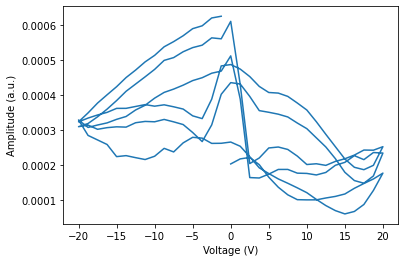

In [84]:
plt.plot(vw, amp_on)
plt.xlabel("Voltage (V)"); plt.ylabel("Amplitude (a.u.)")
plt.show()